# Demo series: Controllers & Agents

---

## Active Inference for controlling a driven damped harmonic oscillator

Wouter Kouw, 02-08-2021

### System

This project considers a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators). Consider $y(t)$ as observed displacement, $x(t)$ as the unobserved state, $u(t)$ as the driving force and $v(t), w(t)$ as measurement and process noise, respectively. The continuous-time dynamics of the system are:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} \, ,
$$
constitute the physical parameters.

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \zeta^{-1}dt)$ with $\zeta$ representing the precision of the process. The measurement noise is also a Wiener process, with $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$ and $\xi$ as precision parameter.

We cast this to the following discrete-time system. Using a forward finite difference method, i.e.,

$$\begin{align}
\frac{d^2 x(t)}{dt^2} = \frac{x_{t+1} - 2x_t + x_{t-1}}{(\Delta t)^2} \, , \quad \text{and} \quad
\frac{d x(t)}{dt} = \frac{x_{t+1} - x_t}{\Delta t} \, ,
\end{align}$$

we get:

$$\begin{align}
m \frac{x_{t+1} - 2x_t + x_{t-1}}{(\Delta t)^2}  =& - c \frac{x_{t+1} - x_t}{\Delta t} -  k x_t + u_t \\
x_{t+1} =&\ -\frac{-2m + k (\Delta t)^2}{m + c \Delta t} x_t - \frac{m - c \Delta t}{m + c \Delta t} = \frac{(\Delta t)^2}{m + c \Delta t} u_t \, .
\end{align}$$

If we substitute variables we get:

$$\begin{align} 
x_{t+1} =&\ \theta_1 x_t + \theta_2 x_{t-1} + \eta u_t \\ 
y_t =&\ x_t + v_t \, .
\end{align}$$

In [4]:
using Pkg
Pkg.activate(".")
Pkg.instantiate();

  Activating environment at `C:\Users\kouww\Research\actinf-oscillator\Project.toml`


In [5]:
using Revise
using Plots
pyplot();

In [96]:
# Sampling step size
Δt = 1.0

# Dynamical parameters
m = 9.0
c = 0.3
k = 1.5

# Measurement noise precision
ξ_true = Inf

# Pack parameters
sys_params = (m, c, k, ξ_true);

In [97]:
# State transition coefficients
θ1 = -(-2*m + k*Δt^2)/(m + c*Δt)
θ2 = -(m - c*Δt)/(m + c*Δt)
θ_true = [θ1, θ2]

# Control coefficient
η_true = Δt^2/(m + c*Δt)

# Pack substituted variables
subs_params = (θ_true, η_true, ξ_true);

In [98]:
function sim_sys(input, state, params)
   "Simulate dynamic system"
    
    # Unpack state
    x_kmin1, x_kmin2 = state
    
    # Unpack parameters
    θ, η, ξ = params
    
    # State transition
    x_k = θ[1]*x_kmin1 + θ[2]*x_kmin2 + η*input
    
    # Generate observation
    y_k = x_k + sqrt(inv(ξ))*randn(1,)[1]
    
    return y_k, x_k    
end;

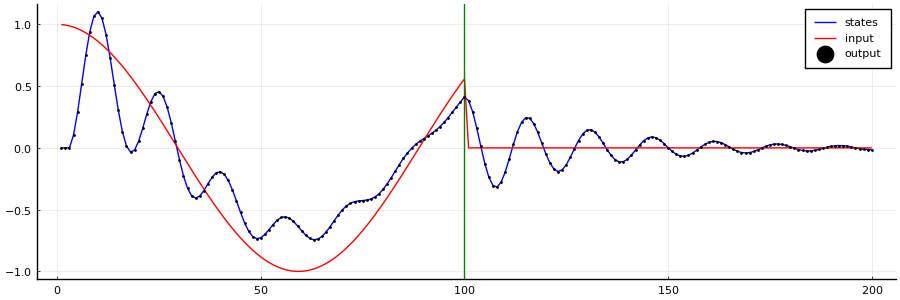

In [99]:
# Time 
T = 200
stop = T-100

# Input signal
input = [cos.((1:stop)./ (6*π)); zeros(length(stop+1:T),)]
# input = zeros(T,); input[1] = 1.0

# Preallocate arrays
states = zeros(T,)
output = zeros(T,)

for k = 4:T
    output[k], states[k] = sim_sys(input[k], states[[k-1, k-2]], subs_params)
end

p100 = plot(1:T, states, linewidth=1, color="blue", label="states", size=(900,300))
plot!(1:T, input, linewidth=1, color="red", label="input")
vline!([stop], color="green", label="")
scatter!(1:T, output, markersize=1, color="black", label="output")

In [100]:
savefig(p100, "figures/example-input-output_seq1.png")

## Model 1: Latent Auto-Regressive model with eXogenous inputs

We cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{k} \\ x_{k-1} \end{bmatrix}}_{z_k} = \Big(\underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{s} \begin{bmatrix} \theta_1 & \theta_2 \end{bmatrix} \Big) \underbrace{\begin{bmatrix} x_{k-1} \\ x_{k-2} \end{bmatrix}}_{z_{k-1}} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t \, ,$$

Next, we add white noise with unknown precision to the first element in the model and white noise with a tiny amount of noise to the other elements:

$$w_k \sim \mathcal{N}\big(0, V(\zeta) \big) \, , \quad \text{with} \quad V(\zeta) = \begin{bmatrix} \zeta^-1 & 0 \\ 0 & \epsilon \end{bmatrix} \, .$$

The state transition can thus be written as:

$$ z_k = \underbrace{\big(S + s\theta^{\top} \big)}_{A(\theta)} z_{k-1} + \underbrace{s\eta}_{B(\eta)} u_k + w_k \, .$$


### Likelihood

Integrating out $w_k$ and $v_t$ lets us formulate the dynamics as a Gaussian state-space model:

$$\begin{align}
z_k \sim&\ \mathcal{N}(A(\theta) z_{k-1} + B(\eta) u_k , V(\zeta)) \\
y_k \sim&\ \mathcal{N}(s^{\top} z_k, \xi^{-1}) \, .
\end{align}$$

### Priors

We choose Gaussian priors for the unknown coefficients and Gamma priors for the unknown noise precisions:

$$\begin{align}
p(\theta) = \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\zeta)= \Gamma(a^{0}_\zeta, b^{0}_\zeta) \, , \quad
p(\xi)= \Gamma(a^{0}_\xi, b^{0}_\xi) \, .
\end{align}$$

We also need a prior distribution for the initial state:

$$ p(z_0) = \mathcal{N}({\bf 0}, V^{z_0}) \, .$$


### Posteriors

We can apply the Bayesian filtering equations to obtain recursive posterior estimates:

$$\begin{align}\label{eq:filtering}
    \underbrace{p(z_k | x_{1:t})}_{\text{state posterior}} &= \frac{\overbrace{p(x_t | z_t)}^{\text{likelihood}}}{\underbrace{p(x_t | x_{1:t-1})}_{\text{evidence}} }  \overbrace{\iint \underbrace{p(z_t| z_{t-1},u_{t})}_{\text{state transition}} \underbrace{q(u_t)}_{\substack{\text{control} \\ \text{signal}}} \underbrace{p(z_{t-1} | x_{1:t-1})}_{\text{state prior}} \d z_{t-1} \d u_t}^{\text{prior predictive $p(z_t | x_{1:t-1})$}} \, ,
\end{align}$$

### Variational Bayesian inference

#### Recognition model

The recognition model will follow the generative model:

$$\begin{align}
q(\theta) = \mathcal{N}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \mathcal{N}(m_{\eta}, v_{\eta}) \ , \quad  
q(\zeta)= \Gamma(a_\zeta, b_\zeta) \, , \quad
q(\xi)= \Gamma(a_\xi, b_\xi) \, .
\end{align}$$

#### Free Energy function

In [101]:
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Optim
using ForneyLab

In [102]:
using LARX

In [103]:
include("util.jl");

In [104]:
graph1 = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))

# Noise precisions
@RV ζ ~ Gamma(placeholder(:a_ζ), placeholder(:b_ζ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV x ~ GaussianMeanPrecision(placeholder(:m_x, dims=(2,)), placeholder(:w_x, dims=(2, 2)), id=:x_k)

# Autoregressive state transition
@RV z ~ LatentAutoregressiveX(θ, x, η, placeholder(:u), ζ, id=:z_k)

# Likelihood
@RV y ~ GaussianMeanPrecision(dot([1. , 0.], z), ξ, id=:y_k)
placeholder(y, :y);

# Specify recognition model
q = PosteriorFactorization(z, x, θ, η, ζ, ξ, ids=[:z, :x, :θ, :η, :ζ, :ξ])

# Specify and compile message passing algorithm
algo = messagePassingAlgorithm([z, x, θ, η, ζ, ξ], q)
eval(Meta.parse(algorithmSourceCode(algo)));

### Experiment 1: Online system Identification from known inputs

In [105]:
# Time horizon
T = 300

# Design input signal
inputs = cos.(range(1, stop=T) * π/6);
# inputs = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T];

In [ ]:
using LARX

In [ ]:
# Preallocation
states = zeros(T,)
outputs = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.01*eye(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.01*eye(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.01*eye(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=0.0, w=.01)
marginals[:ζ] = ProbabilityDistribution(Univariate, Gamma, a=1e3, b=1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e2, b=1e-2)

# Number of variational updates
num_iterations = 10

# Track estimated states
est_states = (zeros(T,), zeros(T,))
est_coeffs = (zeros(T,2), zeros(T,2,2))

@showprogress for k = 3:T
    
    # Execute input and observe output
    outputs[k], states[k] = sim_sys(inputs[k], states[[k-1,k-2]], sys_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => outputs[k],
                       :u => inputs[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_ζ => marginals[:ζ].params[:a],
                       :b_ζ => marginals[:ζ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)        
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update noise precisions
        stepζ!(constraints, marginals)
        stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k] = mn(marginals[:z])[1]
    est_states[2][k] = sqrt(inv(pc(marginals[:z])[1,1]))
    est_coeffs[1][k,:] = mn(marginals[:θ])
    est_coeffs[2][k,:,:] = inv(pc(marginals[:θ]))
end

In [ ]:
p1 = plot(3:T, inputs[3:T], color="red", label="inputs")
p2 = scatter(3:T, outputs[3:T], markersize=2, color="black", label="outputs")
plot!(3:T, est_states[1][3:T], color="purple", label="inferred")
plot!(3:T, est_states[1][3:T], ribbon=[est_states[2][3:T], est_states[2][3:T]], color="purple", label="")
plot(p1, p2, layout=(2,1), size=(900,400))

In [ ]:
p1 = plot(3:T, est_coeffs[1][3:T,1], ribbon=[sqrt.(est_coeffs[2][3:T,1,1]), sqrt.(est_coeffs[2][3:T,1,1])], color="blue", label="θ1 inferred")
plot!(θ_true[1]*ones(T-2,), label="θ1 true", color="green")
p2 = plot(3:T, est_coeffs[1][3:T,2], ribbon=[sqrt.(est_coeffs[2][3:T,2,2]), sqrt.(est_coeffs[2][3:T,2,2])], color="darkblue", label="θ2 inferred")
plot!(θ_true[2]*ones(T-2,), label="θ2 true", color="darkgreen")
plot(p1,p2, layout=(2,1), size=(900,300))

In [ ]:
mn(marginals[:θ])

#### Validate identified system

We validate the identified system by computing simulation error on the validation set.

In [ ]:
# Time horizon
T_val = 1000

# Input signal
inputs_val = sin.(range(1, stop=T_val)*π/6);
# inputs_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val];

In [ ]:
# # Prediction graph
# graph = FactorGraph()

# # Autoregressive node
# @RV z ~ LatentAutoregressiveX(placeholder(:θ, dims=(2,)), placeholder(:x, dims=(2,)), placeholder(:η), placeholder(:u), placeholder(:ζ), id=:z_pred)

# # Inference algorithm
# q = PosteriorFactorization(z, ids=[:_pred])
# algo = messagePassingAlgorithm([z], q)
# eval(Meta.parse(algorithmSourceCode(algo)));

In [ ]:
# Preallocate arrays
states_val = zeros(T_val,)
outputs_val = zeros(T_val,)

# # Initialize marginal
# marginals[:pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=eye(2))

# Preallocate prediction arrays
preds = (zeros(T_val,), zeros(T_val,))

@showprogress for k = 3:T_val
    
    # Simulate forward
    outputs_val[k], states_val[k] = sim_sys(inputs_val[k], states_val[[k-1,k-2]], sys_params)
    
    # Inferred prior states
    z_kmin1 = preds[1][[k-1,k-2]]
    
    # Posterior predictive
    preds[1][k] = mn(marginals[:θ])'*z_kmin1 + mn(marginals[:η])*inputs_val[k]
    preds[2][k] = z_kmin1'*pc(marginals[:θ])*z_kmin1 + inputs_val[k]'*pc(marginals[:η])*inputs_val[k] + inv(mn(marginals[:ξ]))

end

In [ ]:
zoom = 3:min(100,T_val)

# Plot predictions
p23 = scatter(zoom, outputs_val[zoom], label="outputs", xlabel="time (t)", color="black", size=(900,300), legend=:topleft)
plot!(zoom, inputs_val[zoom], label="inputs", color="red")
plot!(zoom, preds[1][zoom], label="simulation", color="blue")
# plot!(zoom, preds[1][zoom], ribbon=[sqrt.(inv.(preds[2][zoom])), sqrt.(inv.(preds[2][zoom]))], label="", color="blue")

In [ ]:
Plots.savefig(p23, "figures/simulations.png")

In [ ]:
# Compute prediction error
sq_pred_error = (preds[1] .- outputs_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))

In [ ]:
Plots.savefig(p24, "figures/sim-errors.png")

### Experiment 2: Online system identification with agent-regulated inputs

In [ ]:
goal_state = (.8, 1e-3)

In [ ]:
function EFE_k(action, prior_state, goal_state, model_params)

    # Unpack model parameters
    θ, η, ζ, ξ = model_params

    # Process noise
    Σ_z = inv(ζ) *[1. 0.; 0. 0.]

    # Helper matrices
    S = [0. 0.; 1. 0.]
    s = [1.; 0.]

    # Unpack prior state     
    μ_kmin = prior_state[1]
    Σ_kmin = prior_state[2]

    # Predicted observation
    y_hat = θ'*μ_kmin + η*action[1]
    
    # Covariance matrix
    Σ_k = Σ_kmin + Σ_z
    Σ_11 = Σ_k
    Σ_21 = s'*Σ_k
    Σ_12 = Σ_k*s
    Σ_22 = s'*Σ_k*s .+ inv(ξ)

    # Calculate conditional entropy
    Σ_cond = Σ_22 - Σ_21 * inv(Σ_11) * Σ_12
    ambiguity = 0.5(log2π + log(Σ_cond[1]) + 1)

    # Risk as KL between marginal and goal prior
    risk = KLDivergence(y_hat, Σ_22[1], goal_state[1], goal_state[2])

    # Update loss.
    return risk + ambiguity
end

In [ ]:
# Time horizon
T = 300
    
# Goal state (mean and std dev)
goal_state = (.8, 1e-4)

# Number of variational updates
num_iterations = 4

# Preallocation
inputs = zeros(T,)
states = zeros(T,)
outputs = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.1*eye(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.1*eye(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2,), w=.1*eye(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=randn(1,)[1], w=.1)
marginals[:ζ] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e2, b=1e-2)

# Track estimated states
est_states = (zeros(T,), zeros(T,))

@showprogress for k = 3:T
    
    "Find control"

    # Pack parameters estimated by model
#     model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:ζ]), mn(marginals[:ξ]))
    model_params = (θ_true, η_true, 1., ξ_true)

    # State prior variable
    prior_state = (mn(marginals[:z]), inv(pc(marginals[:z])))
#     prior_state = (states[[k-1,k-2]], eye(2))

    # Objective function
    G(u_k) = EFE_k(u_k, prior_state, goal_state, model_params)

    # Miminimize EFE
#     results = optimize(G, -1, 1, rand(1,), Fminbox(LBFGS()), Optim.Options(iterations=100); autodiff=:forward)
    results = optimize(G, rand(1,), LBFGS(), Optim.Options(iterations=100); autodiff=:forward)

    # Select first action in policy
    inputs[k] = Optim.minimizer(results)[1]
    
    "Execute control"
    
    # Execute input and observe output
    outputs[k], states[k] = sim_sys(inputs[k], states[[k-1,k-2]], sys_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => outputs[k],
                       :u => inputs[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_ζ => marginals[:ζ].params[:a],
                       :b_ζ => marginals[:ζ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepη!(constraints, marginals)
        stepθ!(constraints, marginals)
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update noise precisions
#         stepζ!(constraints, marginals)
#         stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k] = mn(marginals[:z])[1]
    est_states[2][k] = sqrt(inv(pc(marginals[:z])[1,1]))
    
end

In [ ]:
p1 = plot(3:T, inputs[3:T], color="red", label="inputs")
p2 = plot(3:T, outputs[3:T], color="blue", label="outputs")
plot!(3:T, est_states[1][3:T], color="purple", label="inferred")
plot!(3:T, est_states[1][3:T], ribbon=[est_states[2][3:T], est_states[2][3:T]], color="purple", label="")
plot!(3:T, goal_state[1]*ones(T-2,), color="green", label="goal state")
plot(p1, p2, layout=(2,1), size=(900,400))

#### Validation

In [ ]:
# Time horizon
T_val = 1000

# Input signal
inputs_val = cos.(range(1, stop=T_val)*π/6);
# inputs_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val];

In [ ]:
# Preallocate arrays
states_val = zeros(T_val,)
outputs_val = zeros(T_val,)

# Preallocate prediction arrays
preds = (zeros(T_val,), zeros(T_val,))

@showprogress for k = 3:T_val
    
    # Simulate forward
    outputs_val[k], states_val[k] = sim_sys(inputs_val[k], states_val[[k-1,k-2]], sys_params)
    
    # Inferred prior states
    z_kmin1 = preds[1][[k-1,k-2]]
    
    # Posterior predictive
    preds[1][k] = mn(marginals[:θ])'*z_kmin1 + mn(marginals[:η])*inputs_val[k]
    preds[2][k] = z_kmin1'*pc(marginals[:θ])*z_kmin1 + inputs_val[k]'*pc(marginals[:η])*inputs_val[k] + mn(marginals[:ξ])

end

In [ ]:
zoom = 3:T_val

# Plot predictions
p23 = plot(zoom, outputs_val[zoom], label="outputs", xlabel="time (t)", color="black", size=(900,300))
plot!(zoom, inputs_val[zoom], label="inputs", color="red")
plot!(zoom, preds[1][zoom], label="simulation", color="blue")
# plot!(zoom, preds[1][zoom], ribbon=[sqrt.(inv.(preds[2][zoom])), sqrt.(inv.(preds[2][zoom]))], label="", color="blue")

In [ ]:
# Compute prediction error
sq_pred_error = (preds[1] .- outputs_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))